# ESA Project: Fake or Real: The Impostor Hunt in Texts

This notebook is dedicated to **exploratory data analysis (EDA)**.  
It covers:

- Exploring the processed datasets generated in the data preparation notebook.  
- Visualizing label distributions and text lengths.  
- Generating insights to guide feature engineering and modeling.  
- Checking for anomalies or patterns in the text data.

# Import librairies

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import os

sns.set_theme()

# Load datasets

In [2]:
DATA_PATH = Path("../data/processed")
PLOTS_PATH = Path("../results/plots")
PLOTS_PATH.mkdir(parents=True, exist_ok=True)

train_df = pd.read_csv(DATA_PATH / "train_cleaned.csv")
val_df = pd.read_csv(DATA_PATH / "val_cleaned.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("\nTrain label distribution:\n", train_df['real_text_id'].value_counts())
print("\nValidation label distribution:\n", val_df['real_text_id'].value_counts())

Train shape: (74, 4)
Validation shape: (19, 4)

Train label distribution:
 real_text_id
2    38
1    36
Name: count, dtype: int64

Validation label distribution:
 real_text_id
2    10
1     9
Name: count, dtype: int64


# Quick Exploratory Data Analysis

## Text length features

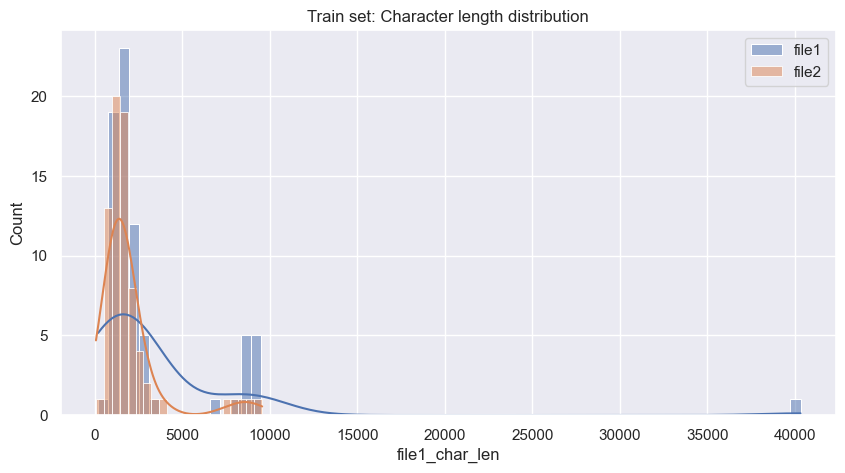

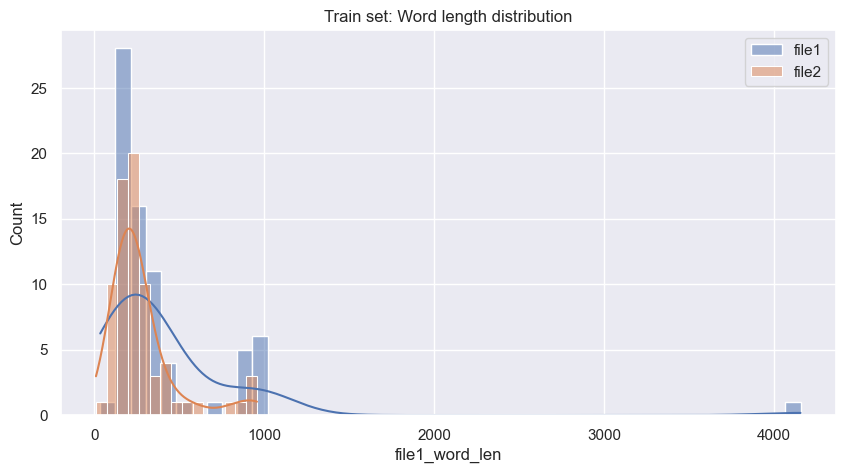

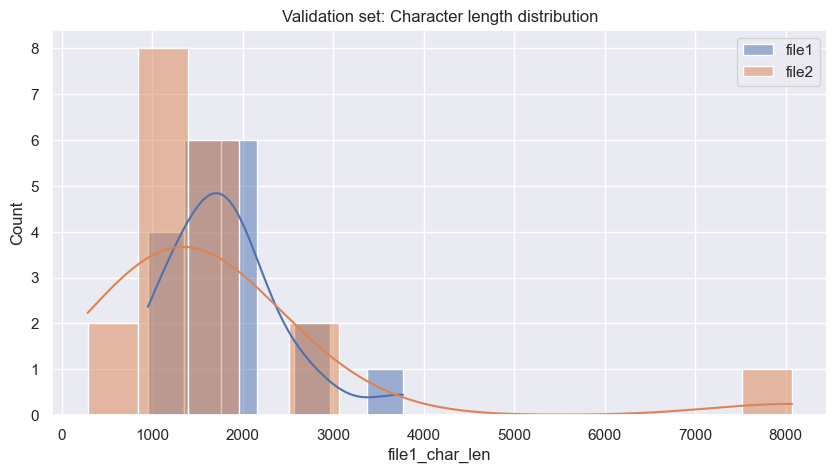

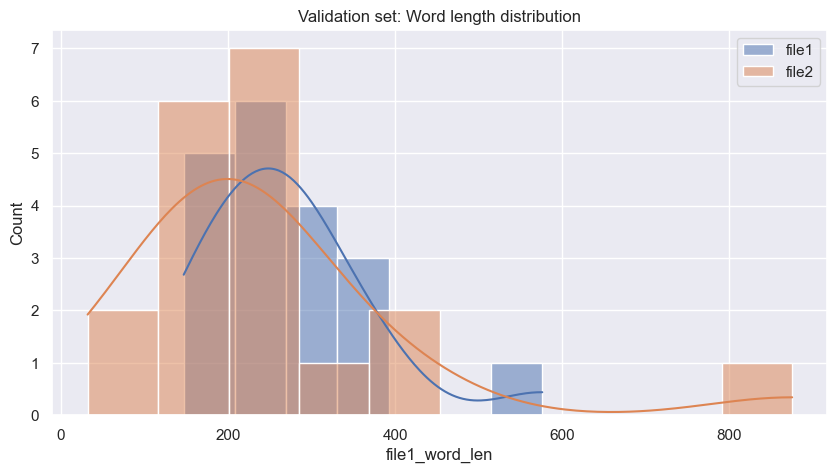

In [3]:
# Looping over both datasets - usinge the same logic for both datasets without duplicating code
for df, name in zip([train_df, val_df], ['train', 'validation']):
    # Count nb of characters in each text
    df['file1_char_len'] = df['file1_text'].apply(len)
    df['file2_char_len'] = df['file2_text'].apply(len)
    # Count nb of words in each text
    df['file1_word_len'] = df['file1_text'].apply(lambda x: len(str(x).split()))
    df['file2_word_len'] = df['file2_text'].apply(lambda x: len(str(x).split()))
    
    # Plot histograms
    plt.figure(figsize=(10,5))
    sns.histplot(df['file1_char_len'], label='file1', kde=True)
    sns.histplot(df['file2_char_len'], label='file2', kde=True)
    plt.title(f"{name.capitalize()} set: Character length distribution")
    plt.legend()
    plt.savefig(PLOTS_PATH / f"{name}_char_len_dist.png")
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.histplot(df['file1_word_len'], label='file1', kde=True)
    sns.histplot(df['file2_word_len'], label='file2', kde=True)
    plt.title(f"{name.capitalize()} set: Word length distribution")
    plt.legend()
    plt.savefig(PLOTS_PATH / f"{name}_word_len_dist.png")
    plt.show()


,label,text,article_id,char_len,word_len
0,real,We determine accurate values for the total lit...,63,2525,406
1,fake,We determine accurate values for the total lit...,63,7101,751
2,real,The QUEST camera has 160 megapixels and was cr...,30,1368,219
3,fake,The 160-megapixel **Edam** camera was designed...,30,2076,337
4,real,The VLT has enabled two major projects using t...,45,1400,206


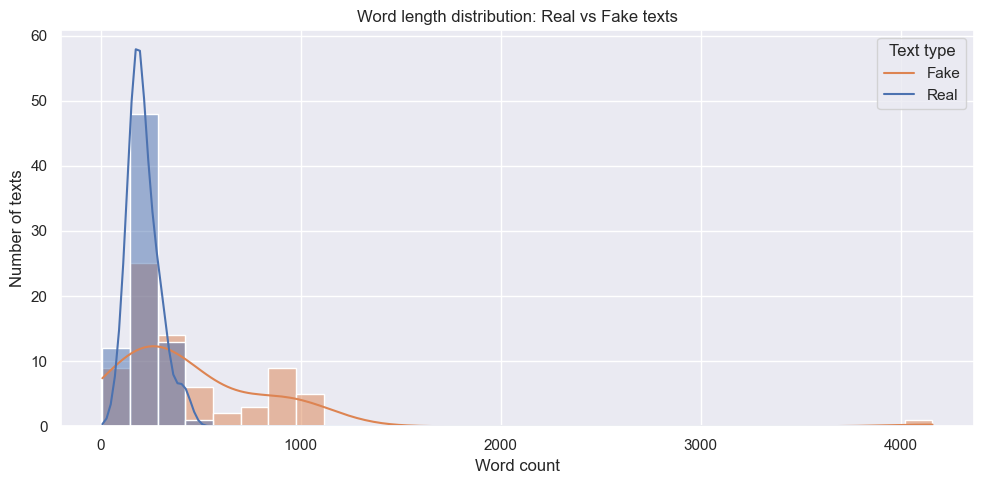

In [4]:
# Reorganize the dataset where each row represents a single text labeled as real or fake
def build_real_fake_view(df):
    rows = []
    for _, row in df.iterrows():
        # Real text
        if row["real_text_id"] == 1:
            real_text = row["file1_text"]
            fake_text = row["file2_text"]
        else:
            real_text = row["file2_text"]
            fake_text = row["file1_text"]

        rows.append({"label": "real", "text": real_text, "article_id": row["id"]})
        rows.append({"label": "fake", "text": fake_text, "article_id": row["id"]})
    return pd.DataFrame(rows)

# Apply to train set and add character and word lengths
real_fake_train = build_real_fake_view(train_df)
real_fake_train["char_len"] = real_fake_train["text"].str.len()
real_fake_train["word_len"] = real_fake_train["text"].apply(lambda x: len(str(x).split()))

display(real_fake_train.head())

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(data=real_fake_train, x="word_len", hue="label", kde=True, bins=30)
plt.title("Word length distribution: Real vs Fake texts")
plt.xlabel("Word count")
plt.ylabel("Number of texts")
plt.legend(title="Text type", labels=["Fake", "Real"])
plt.tight_layout()
plt.show()


In [5]:
for i in ['real', 'fake']:
    print('-' * 80)
    print('Text labeled '+ i)
    print('-' * 80)
    display(real_fake_train[real_fake_train.label == i].describe())

--------------------------------------------------------------------------------
Text labeled real
--------------------------------------------------------------------------------


,article_id,char_len,word_len
count,74.00000,74.000000,74.000000
mean,50.27027,1438.216216,215.743243
std,27.83823,488.062939,76.868694
min,0.00000,552.000000,75.000000
25%,28.25000,1107.000000,167.000000
50%,53.50000,1370.500000,199.000000
75%,73.75000,1667.250000,255.500000
max,93.00000,2734.000000,446.000000


--------------------------------------------------------------------------------
Text labeled fake
--------------------------------------------------------------------------------


,article_id,char_len,word_len
count,74.00000,74.000000,74.000000
mean,50.27027,3845.121622,471.648649
std,27.83823,5238.536126,527.368173
min,0.00000,69.000000,9.000000
25%,28.25000,1428.250000,213.250000
50%,53.50000,1949.000000,296.500000
75%,73.75000,3860.750000,601.750000
max,93.00000,40316.000000,4158.000000


- Fake texts have on average more than twice more words than real texts
- Real texts are relatively consistent in length while fake texts vary widely
- Some fake texts are extremely long (~4000 words) while real texts maximum words are ~450 words

## Top TF-IDF words for real vs fake

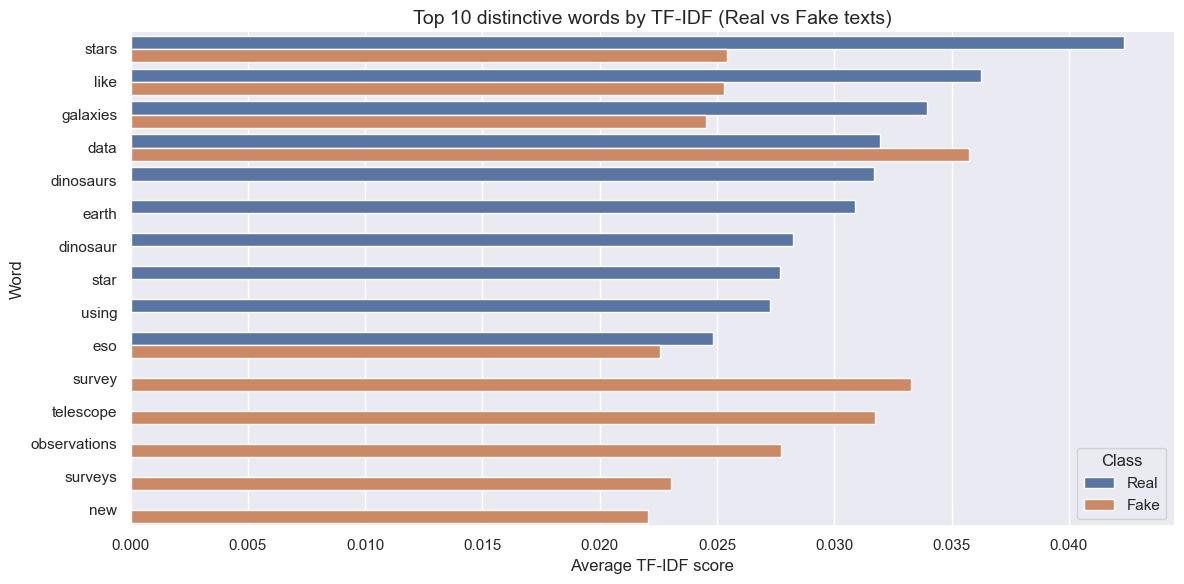

In [6]:
# Combine both text files into one text per article (for TF-IDF)
train_df['combined_text'] = train_df['file1_text'] + " " + train_df['file2_text']

# Initialize TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(train_df['combined_text'])
feature_names = np.array(vectorizer.get_feature_names_out())

# Create TF-IDF DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
tfidf_df['label'] = train_df['real_text_id']
tfidf_features = [col for col in tfidf_df.columns if col != 'label']

# Compute average TF-IDF scores for each class
real_means = (
    tfidf_df.loc[tfidf_df['label'] == 1, tfidf_features]
    .mean()
    .sort_values(ascending=False)[:10]
)
fake_means = (
    tfidf_df.loc[tfidf_df['label'] == 2, tfidf_features]
    .mean()
    .sort_values(ascending=False)[:10]
)

# Combine into one DataFrame for plotting
top_real = pd.DataFrame({'word': real_means.index, 'tfidf': real_means.values, 'label': 'Real'})
top_fake = pd.DataFrame({'word': fake_means.index, 'tfidf': fake_means.values, 'label': 'Fake'})
top_words = pd.concat([top_real, top_fake])

# Plot top TF-IDF words
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_words,
    x='tfidf', y='word',
    hue='label'
)
plt.title("Top 10 distinctive words by TF-IDF (Real vs Fake texts)", fontsize=14)
plt.xlabel("Average TF-IDF score")
plt.ylabel("Word")
plt.legend(title="Class", loc="lower right")
sns.despine()
plt.tight_layout()
plt.savefig(PLOTS_PATH / "tfidf_top_words_real_vs_fake.png")
plt.show()



- Real texts are more concentrated around concrete, scientific vocabulary (stars, galaxies, data, earth,...)
- Fake texts are more diffuse, referential, “science-sounding” words (survey, surveys, observations, new,...)

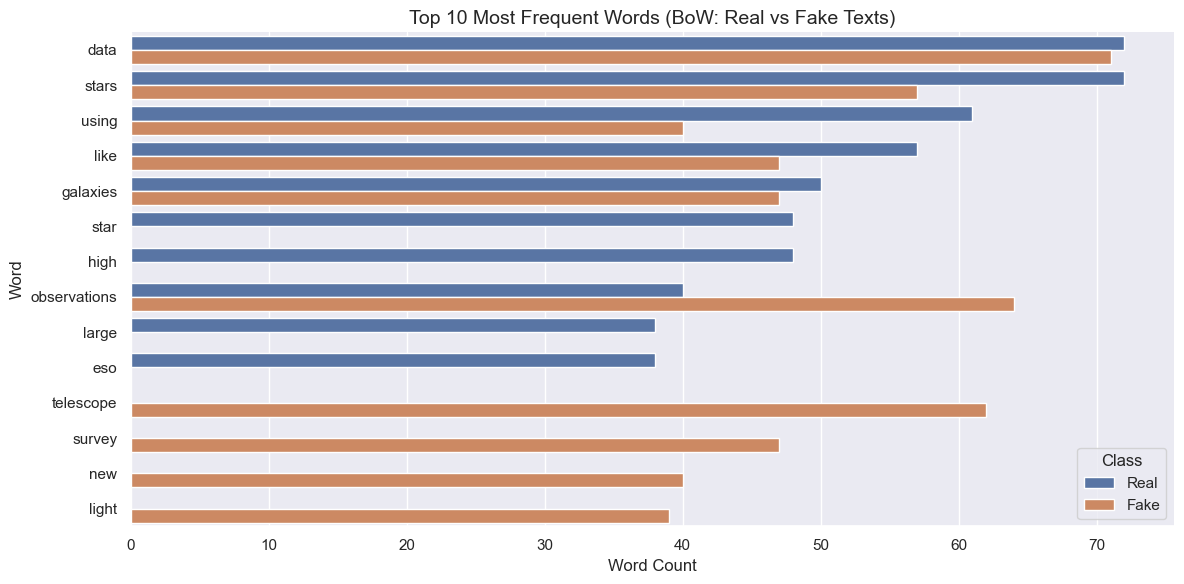

In [ ]:
# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(train_df['combined_text'])
bow_feature_names = np.array(bow_vectorizer.get_feature_names_out())

# Create a DataFrame for BoW features
bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_feature_names)
bow_df['label'] = train_df['real_text_id']

# Compute top 10 word counts per class
real_counts = bow_df[bow_df['label'] == 1][bow_feature_names].sum().sort_values(ascending=False)[:10]
fake_counts = bow_df[bow_df['label'] == 2][bow_feature_names].sum().sort_values(ascending=False)[:10]

# Combine for plotting
top_real_bow = pd.DataFrame({'word': real_counts.index, 'count': real_counts.values, 'label': 'Real'})
top_fake_bow = pd.DataFrame({'word': fake_counts.index, 'count': fake_counts.values, 'label': 'Fake'})
top_bow_words = pd.concat([top_real_bow, top_fake_bow])

# Plot top words
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bow_words, x='count', y='word', hue='label')
plt.title("Top 10 most frequent words (BoW: Real vs Fake texts)", fontsize=14)
plt.xlabel("Word count")
plt.ylabel("Word")
plt.legend(title="Class", loc="lower right")
sns.despine()
plt.tight_layout()
plt.savefig(PLOTS_PATH / "bow_top_words_real_vs_fake.png")
plt.show()


# Save the updated CSVs with new features

In [7]:
train_df.to_csv(DATA_PATH / "train_eda_features.csv", index=False)
val_df.to_csv(DATA_PATH / "val_eda_features.csv", index=False)
print("EDA features saved to processed folder")

EDA features saved to processed folder


# End of EDA notebook